In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# 计算xgboost+CNNBiLSTM
df_xgboost = pd.read_csv("./result/XGBoostpre-best.csv")
df_CNNBiLSTM = pd.read_csv("./result/CNN-BiLSTMpre-best.csv")

In [2]:
# 计算基模型的累计误差
def CumMSE(df_model:pd.DataFrame):
    """
    df_model第一列为true，第二列为pre
    """
    cum_mse = []
    for i in range(len(df_model)):
        cum_mse.append(mean_squared_error(df_model.iloc[:i+1,0],df_model.iloc[:i+1,1]))
    return cum_mse

cum_mse_xgboost = CumMSE(df_xgboost)
cum_mse_CNNBiLSTM = CumMSE(df_CNNBiLSTM)

# 计算组合权重
def CombineWeight(cum_mse1:list,cum_mse2:list):
    """
    :parameters:
    cum_mse1: 模型1累计误差 
    cum_mse2: 模型2累计误差
    
    :return: 
    模型1的组合权重
    """
    weightList = []
    for i in range(len(cum_mse1)):
        weightOfModel1 = cum_mse1[i]/sum([cum_mse1[i],cum_mse2[i]])
        weightList.append(weightOfModel1)
    return weightList

weight_xgboost = CombineWeight(cum_mse_xgboost,cum_mse_CNNBiLSTM)
    

In [12]:
df_xgboost.loc[:,'y_true'].tolist()

[0.21986437,
 0.20608182,
 0.21198863,
 0.21789543,
 0.21767665,
 0.21461387,
 0.22292715,
 0.23517829,
 0.23583461,
 0.22598994,
 0.23670968,
 0.26646248,
 0.26974404,
 0.2714942,
 0.26996282,
 0.2894334,
 0.31152922,
 0.33143732,
 0.33362502,
 0.33471888,
 0.34675127,
 0.36447167,
 0.38109824,
 0.38569242,
 0.4042879,
 0.43294683,
 0.4532925,
 0.45307374,
 0.450886,
 0.4664187,
 0.48523298,
 0.5178298,
 0.5217677,
 0.5287683,
 0.54036313,
 0.54561365,
 0.56289655,
 0.59243053,
 0.59680593,
 0.5978998,
 0.60643184,
 0.6121199,
 0.6178079,
 0.6385911,
 0.65412384,
 0.66659373,
 0.6563115,
 0.68650186,
 0.69087726,
 0.69262743,
 0.6904397,
 0.70159703,
 0.71756727,
 0.7217239,
 0.72369283,
 0.7160359,
 0.71625465,
 0.72063005,
 0.7180048,
 0.73266244,
 0.7440385,
 0.7337563,
 0.7234741,
 0.7201925,
 0.7147232,
 0.7138482,
 0.7210676,
 0.7223802,
 0.71100414,
 0.69722164,
 0.7024721,
 0.68387663,
 0.68212646,
 0.68190765,
 0.68081385,
 0.6462481,
 0.6506235,
 0.6479983,
 0.6285277,
 0.61

In [3]:
# 计算xgboost+CNNBiLSTM组合预测值
def CombineModel(df_Model1:pd.DataFrame,df_Model2:pd.DataFrame,combineWeightOfModel1:list):
    """
    :parameters:
    df_Model1: 模型1的结果
    df_Model2: 模型2的结果
    combineWeightOfModel1: 模型1的组合权重

    :return: 预测值
    """
    y_pre = []
    for idx,weight in enumerate(combineWeightOfModel1):
        prediction = df_Model1['y_pre'][idx] *weight + df_Model2['y_pre'][idx]*(1-weight)
        y_pre.append(prediction)
    return y_pre

y_pre = CombineModel(df_xgboost,df_CNNBiLSTM,weight_xgboost)
y = df_xgboost.loc[:,'y_true']


In [4]:
# 计算xgboost+CNNBiLSTM组合评价
r2Score = r2_score(y_true=y, y_pred=y_pre)
meanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
meanAbsoluteError = mean_absolute_error(y_true=y, y_pred=y_pre)
print("r2Score: ", r2Score)
print("meanSquaredError: ", meanSquaredError)
print('RMSE: ',np.sqrt(meanSquaredError))
print("meanAbsoluteError: ", meanAbsoluteError)


r2Score:  0.987548102877347
meanSquaredError:  0.0006429864056401547
RMSE:  0.025357176610185817
meanAbsoluteError:  0.008779824541443054


In [23]:
df_evaluate = pd.read_csv("./result/组合模型结果.csv")
df_evaluate.columns

Index(['Model_name', 'r2-score', 'MSE', 'RMSE', 'MAE'], dtype='object')

In [26]:
df_evaluate = df_evaluate[['Model_name', 'MSE', 'RMSE', 'MAE']].melt(id_vars='Model_name')
df_evaluate

,Model_name,variable,value
0,BiLSTM,MSE,0.001828
1,XGBoost,MSE,0.000961
2,CNN-BiLSTM,MSE,0.001383
3,XGBoost+BiLSTM,MSE,0.001344
4,XGBoost+CNN-BiLSTM,MSE,0.000643
5,BiLSTM,RMSE,0.042752
6,XGBoost,RMSE,0.031005
7,CNN-BiLSTM,RMSE,0.037185
8,XGBoost+BiLSTM,RMSE,0.036661
9,XGBoost+CNN-BiLSTM,RMSE,0.025357


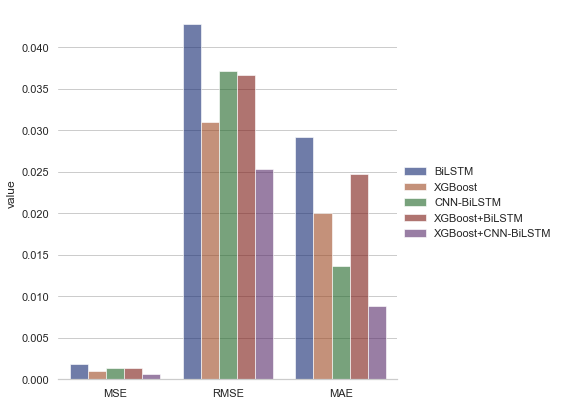

In [27]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_evaluate, kind="bar",
    x="variable"	, y="value", hue="Model_name",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "value")
g.legend.set_title("")